# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [ ]:
# Install the required libraries
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [45]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col="Date",
    parse_dates=False  # Load as string first
)

# Convert index to datetime explicitly with correct format
df_mercado_trends.index = pd.to_datetime(df_mercado_trends.index, format="%m/%d/%y %H:%M", errors="coerce")

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [46]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


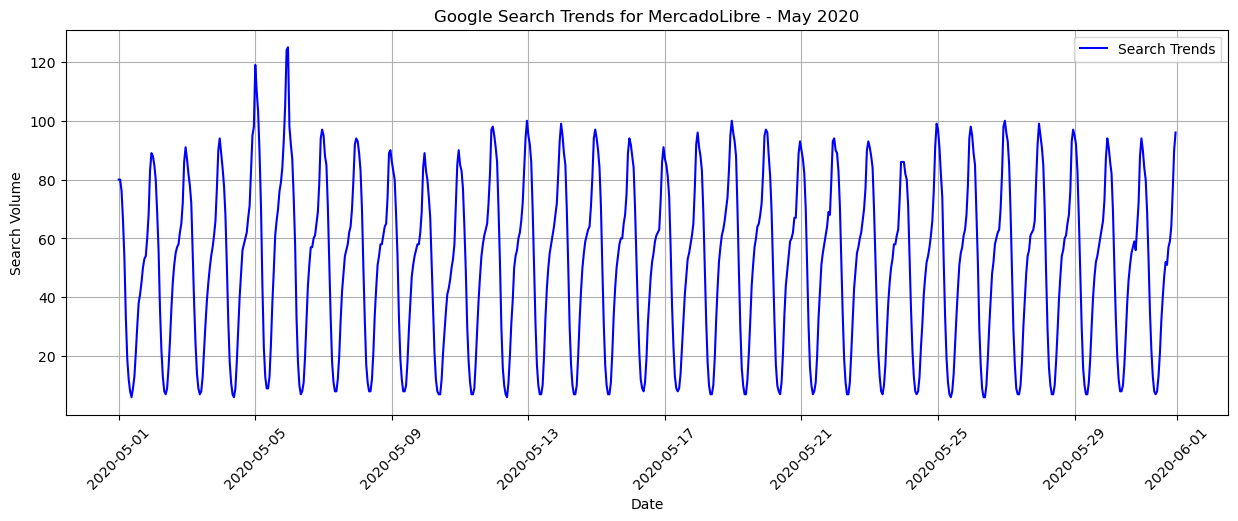

In [47]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc["2020-05"]

# Plot to visualize the data for May 2020
plt.figure(figsize=(15, 5))
plt.plot(df_may_2020.index, df_may_2020["Search Trends"], label="Search Trends", color="blue")

# Formatting
plt.xlabel("Date")
plt.ylabel("Search Volume")
plt.title("Google Search Trends for MercadoLibre - May 2020")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [48]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020['Search Trends'].sum()

# View the traffic_may_2020 value
print(f"Total Search Traffic for May 2020: {traffic_may_2020}")

Total Search Traffic for May 2020: 38181


In [50]:
# Calcluate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
monthly_traffic = df_mercado_trends['Search Trends'].resample('ME').sum()

median_monthly_traffic = monthly_traffic.median()

# View the median_monthly_traffic value
print(f"Median Monthly Search Traffic Across All Months: {median_monthly_traffic}")

Median Monthly Search Traffic Across All Months: 35172.5


In [51]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
# Calculate the percentage difference
percentage_difference = ((traffic_may_2020 - median_monthly_traffic) / median_monthly_traffic) * 100

# Print the result
print(f"Percentage difference between May 2020 search traffic and median: {percentage_difference:.2f}%")

# Interpret the result
if traffic_may_2020 > median_monthly_traffic:
    print("May 2020 had higher than usual search traffic.")
else:
    print("May 2020 had lower or typical search traffic.")


Percentage difference between May 2020 search traffic and median: 8.55%
May 2020 had higher than usual search traffic.


In [52]:
# Step 1: Compare the search traffic for May 2020 to the overall monthly median
if traffic_may_2020 > median_monthly_traffic:
    print("The Google search traffic for May 2020 is higher than the monthly median across all months.")
elif traffic_may_2020 < median_monthly_traffic:
    print("The Google search traffic for May 2020 is lower than the monthly median across all months.")
else:
    print("The Google search traffic for May 2020 is equal to the monthly median across all months.")


The Google search traffic for May 2020 is higher than the monthly median across all months.


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes. The data shows that May 2020 had higher than usual search traffic compared to the median.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

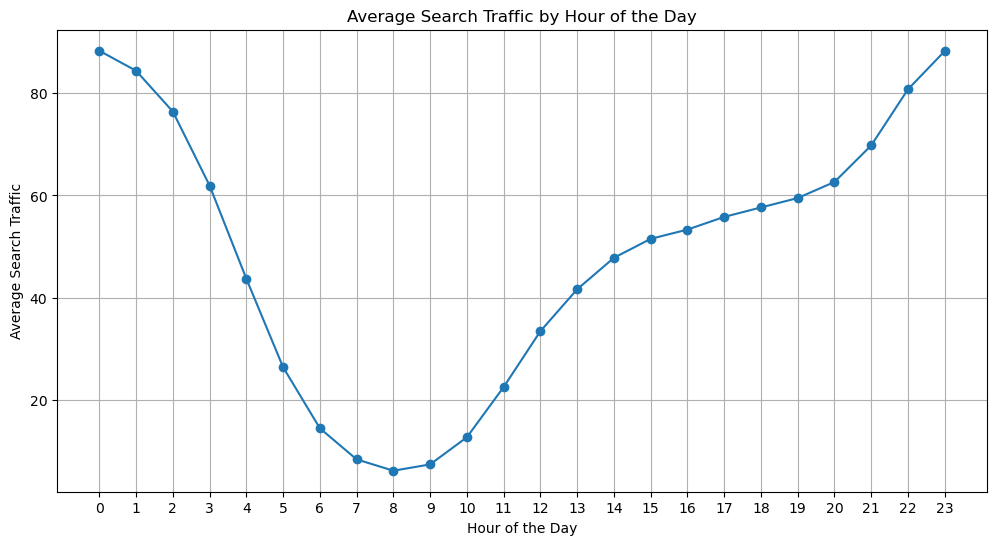

In [53]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
# Group the search data by hour of the day and calculate the mean
hourly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour).mean()

# Plot the average search traffic by hour
plt.figure(figsize=(12, 6))
plt.plot(hourly_traffic.index, hourly_traffic['Search Trends'], marker='o', linestyle='-')

# Labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Average Search Traffic")
plt.title("Average Search Traffic by Hour of the Day")
plt.xticks(range(0, 24))  # Ensure all hours are labeled
plt.grid(True)

# Show the plot
plt.show()


#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

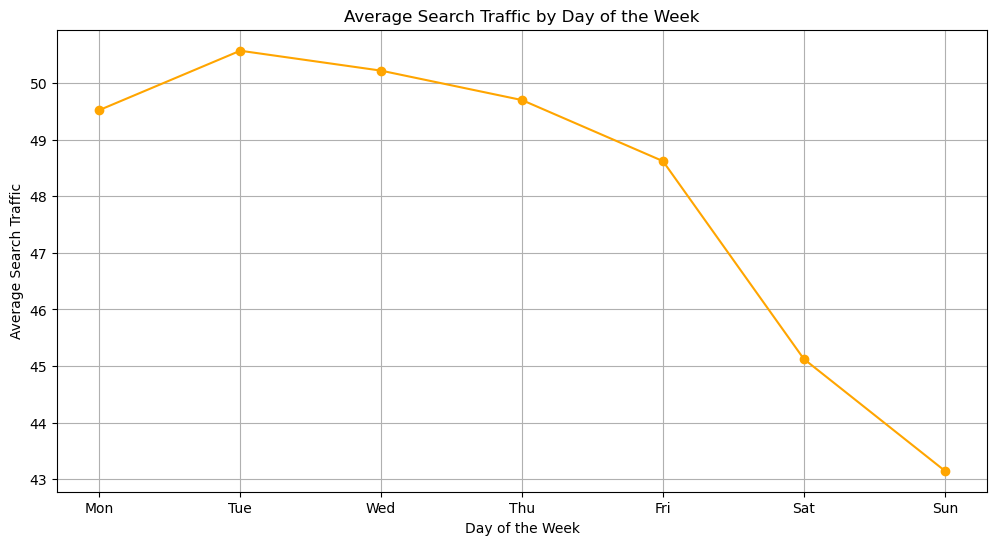

In [54]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
daily_traffic = df_mercado_trends.groupby(df_mercado_trends.index.dayofweek).mean()

# Plot the average search traffic by day of the week
plt.figure(figsize=(12, 6))
plt.plot(daily_traffic.index, daily_traffic['Search Trends'], marker='o', linestyle='-', color='orange')

# Labels and title
plt.xlabel("Day of the Week")
plt.ylabel("Average Search Traffic")
plt.title("Average Search Traffic by Day of the Week")
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  # Day names
plt.grid(True)

# Show the plot
plt.show()

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

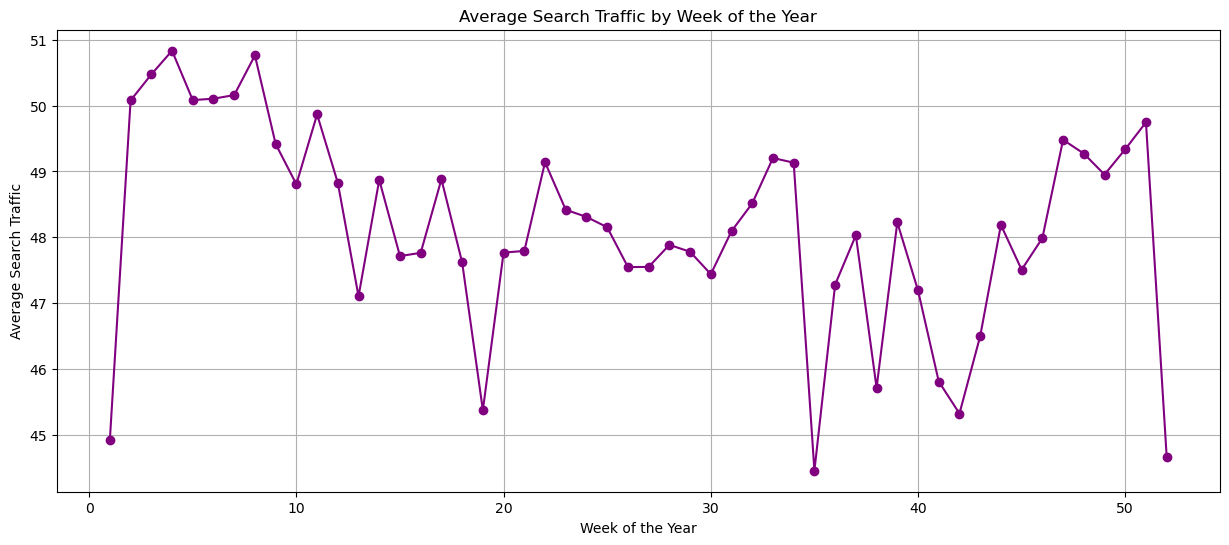

In [55]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
weekly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean()

# Plot the average search traffic by week of the year
plt.figure(figsize=(15, 6))
plt.plot(weekly_traffic.index, weekly_traffic['Search Trends'], marker='o', linestyle='-', color='purple')

# Labels and title
plt.xlabel("Week of the Year")
plt.ylabel("Average Search Traffic")
plt.title("Average Search Traffic by Week of the Year")
plt.grid(True)

# Show the plot
plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** It seems like Tuesday towards the early part of the month has the most traffic. The data also shows that the hghest traffic times are between 1900 to 0300.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [56]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


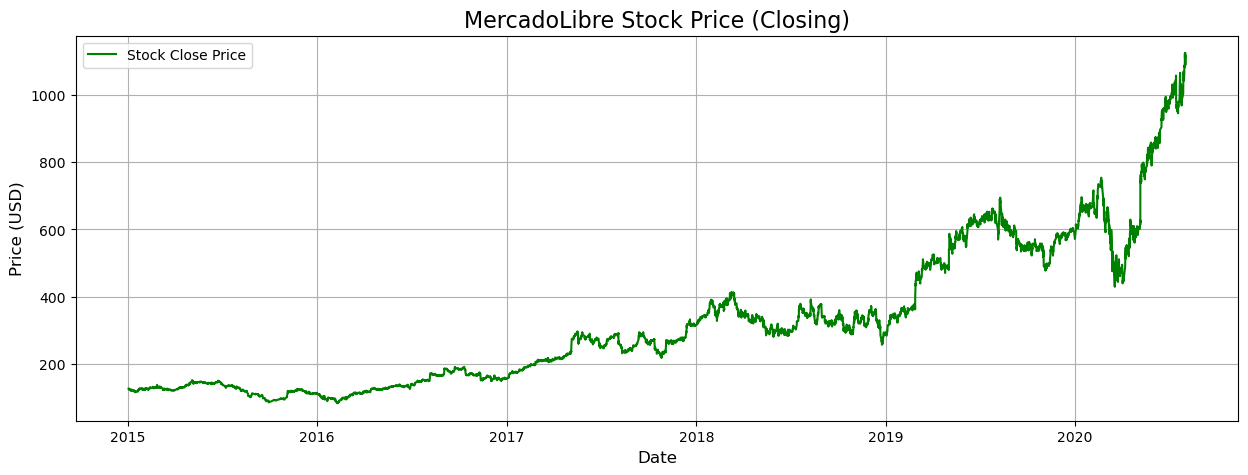

In [57]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.figure(figsize=(15, 5))
plt.plot(df_mercado_stock['close'], color='green', label='Stock Close Price')
plt.title('MercadoLibre Stock Price (Closing)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [63]:
df_mercado_stock.head()

,close
date,
2016-06-01 09:00:00,135.16
2016-06-01 10:00:00,136.63
2016-06-01 11:00:00,136.56
2016-06-01 12:00:00,136.42
2016-06-01 13:00:00,136.10


In [62]:
df_mercado_trends.head()

,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


In [65]:
# Concatenate the stock price data with the search trends data
df_merged = pd.concat([df_mercado_trends, df_mercado_stock], axis=1)

# Drop rows with missing values
df_merged = df_merged.dropna()

# Ensure the index is correctly labeled
df_merged.index.name = "date"

# View the first few rows
display(df_merged.head())



,Search Trends,close
date,,
2016-06-01 09:00:00,6.0,135.16
2016-06-01 10:00:00,12.0,136.63
2016-06-01 11:00:00,22.0,136.56
2016-06-01 12:00:00,33.0,136.42
2016-06-01 13:00:00,40.0,136.10


In [66]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36176 entries, 2016-06-01 09:00:00 to 2020-07-31 15:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Search Trends  36176 non-null  float64
 1   close          36176 non-null  float64
dtypes: float64(2)
memory usage: 847.9 KB


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [67]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = df_merged.loc['2020-01-01':'2020-06-30']

# View the first and last five rows of the first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())


,Search Trends,close
date,,
2020-01-01 00:00:00,37.0,572.53
2020-01-01 01:00:00,39.0,572.53
2020-01-01 02:00:00,0.0,572.53
2020-01-01 03:00:00,0.0,572.53
2020-01-01 04:00:00,0.0,572.53


,Search Trends,close
date,,
2020-06-30 19:00:00,59.0,984.93
2020-06-30 20:00:00,62.0,984.93
2020-06-30 21:00:00,71.0,984.93
2020-06-30 22:00:00,85.0,984.93
2020-06-30 23:00:00,93.0,984.93


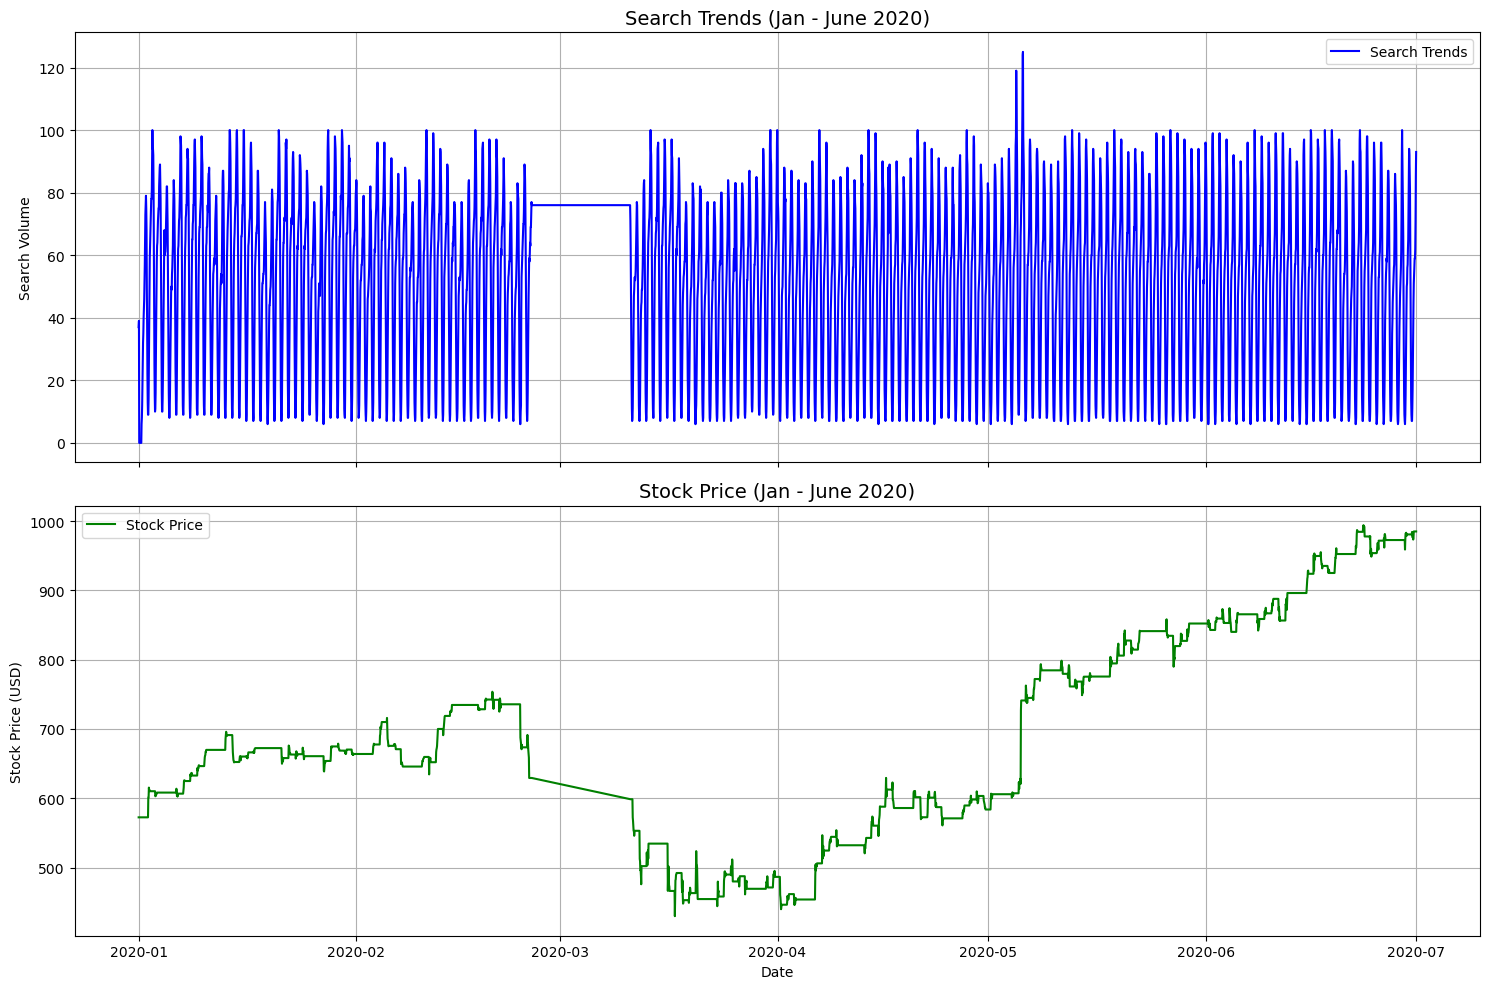

In [70]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

# Plot Search Trends
axes[0].plot(first_half_2020.index, first_half_2020["Search Trends"], color="blue", label="Search Trends")
axes[0].set_title("Search Trends (Jan - June 2020)", fontsize=14)
axes[0].set_ylabel("Search Volume")
axes[0].legend()
axes[0].grid(True)

# Plot Stock Price
axes[1].plot(first_half_2020.index, first_half_2020["close"], color="green", label="Stock Price")
axes[1].set_title("Stock Price (Jan - June 2020)", fontsize=14)
axes[1].set_ylabel("Stock Price (USD)")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Both time series indicate that there was a lag in March of 2020. However, search trends seem to stay fairly consistent while close data shows an upward trend.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [71]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
# Create the "Lagged Search Trends" column by shifting the 'Search Trends' by 1 hour
df_merged['Lagged Search Trends'] = df_merged['Search Trends'].shift(1)



In [72]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window

# Calculate the hourly stock return (percentage change in stock price)
df_merged['Hourly Stock Return'] = df_merged['close'].pct_change() * 100

# Calculate the rolling 4-hour standard deviation for stock returns to get stock volatility
df_merged['Stock Volatility'] = df_merged['Hourly Stock Return'].rolling(window=4).std()

# Display the first few rows to verify the new columns
display(df_merged.head())


,Search Trends,close,Lagged Search Trends,Hourly Stock Return,Stock Volatility
date,,,,,
2016-06-01 09:00:00,6.0,135.16,NaN,NaN,NaN
2016-06-01 10:00:00,12.0,136.63,6.0,1.087600,NaN
2016-06-01 11:00:00,22.0,136.56,12.0,-0.051233,NaN
2016-06-01 12:00:00,33.0,136.42,22.0,-0.102519,NaN
2016-06-01 13:00:00,40.0,136.10,33.0,-0.234570,0.613401


<Figure size 1500x600 with 0 Axes>

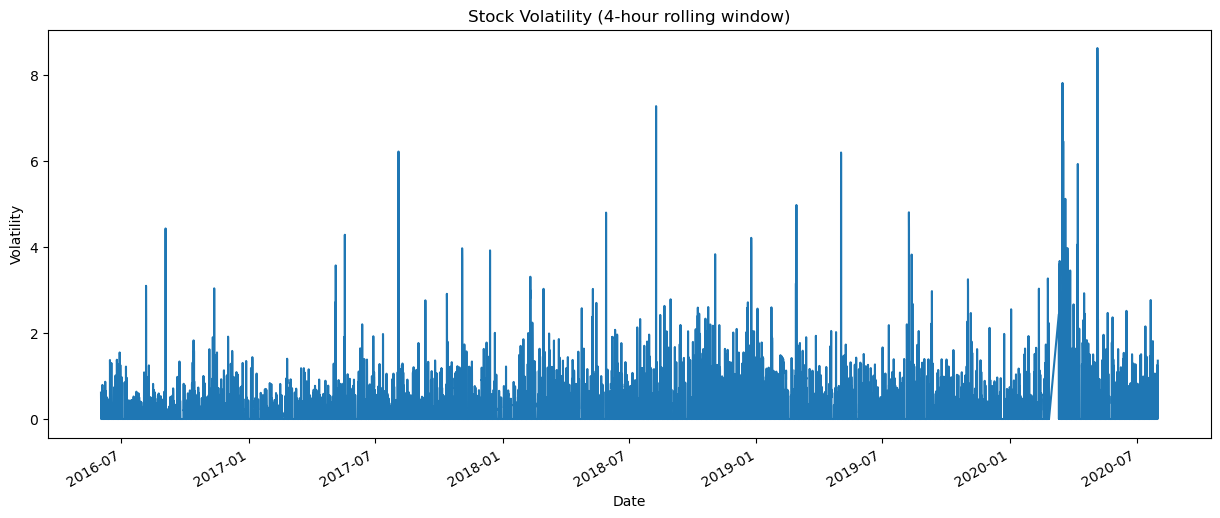

In [74]:
# Visualize the stock volatility
# Plot the stock volatility
plt.figure(figsize=(15, 6))
df_merged['Stock Volatility'].plot()
plt.title('Stock Volatility (4-hour rolling window)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()



**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [76]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36176 entries, 2016-06-01 09:00:00 to 2020-07-31 15:00:00
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Search Trends         36176 non-null  float64
 1   close                 36176 non-null  float64
 2   Lagged Search Trends  36175 non-null  float64
 3   Hourly Stock Return   36175 non-null  float64
 4   Stock Volatility      36172 non-null  float64
dtypes: float64(5)
memory usage: 2.7 MB


In [77]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price

# Calculate the hourly stock return (percentage change in closing price)
df_merged['Hourly Stock Return'] = df_merged['close'].pct_change() * 100

# Display the first few rows to confirm the new column
display(df_merged.head())



,Search Trends,close,Lagged Search Trends,Hourly Stock Return,Stock Volatility
date,,,,,
2016-06-01 09:00:00,6.0,135.16,NaN,NaN,NaN
2016-06-01 10:00:00,12.0,136.63,6.0,1.087600,NaN
2016-06-01 11:00:00,22.0,136.56,12.0,-0.051233,NaN
2016-06-01 12:00:00,33.0,136.42,22.0,-0.102519,NaN
2016-06-01 13:00:00,40.0,136.10,33.0,-0.234570,0.613401


In [78]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
df_merged.head(5)

df_merged.tail(5)

,Search Trends,close,Lagged Search Trends,Hourly Stock Return,Stock Volatility
date,,,,,
2020-07-31 11:00:00,20.0,1105.780,11.0,0.637986,1.110301
2020-07-31 12:00:00,32.0,1087.925,20.0,-1.614697,1.354852
2020-07-31 13:00:00,41.0,1095.800,32.0,0.723855,1.329459
2020-07-31 14:00:00,47.0,1110.650,41.0,1.355174,1.300123
2020-07-31 15:00:00,53.0,1122.510,47.0,1.067843,1.356602


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [79]:

# Construct a correlation table for Stock Volatility, Lagged Search Trends, and Hourly Stock Return
# Select relevant columns for correlation analysis
correlation_table = df_merged[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

# Display the correlation table
display(correlation_table)



,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.259461,0.056287
Lagged Search Trends,-0.259461,1.000000,-0.018655
Hourly Stock Return,0.056287,-0.018655,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** It looks like the stock volatility stays constant throughout. It also doesn't seem like the lagged searches seem to affect the returns as they show a negative correlation.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [80]:
# Check the column names after resetting the index
print(df_merged.columns)


Index(['Search Trends', 'close', 'Lagged Search Trends', 'Hourly Stock Return',
       'Stock Volatility'],
      dtype='object')


In [81]:
# Reset index to make the date a column
df_prophet = df_merged.reset_index()

# Rename columns to match Prophet's requirements
df_prophet = df_prophet.rename(columns={'date': 'ds', 'Search Trends': 'y'})

# Check for missing values
print(df_prophet.isnull().sum())

# Display the first few rows
display(df_prophet.head())


ds                      0
y                       0
close                   0
Lagged Search Trends    1
Hourly Stock Return     1
Stock Volatility        4
dtype: int64


,ds,y,close,Lagged Search Trends,Hourly Stock Return,Stock Volatility
0,2016-06-01 09:00:00,6.0,135.16,NaN,NaN,NaN
1,2016-06-01 10:00:00,12.0,136.63,6.0,1.087600,NaN
2,2016-06-01 11:00:00,22.0,136.56,12.0,-0.051233,NaN
3,2016-06-01 12:00:00,33.0,136.42,22.0,-0.102519,NaN
4,2016-06-01 13:00:00,40.0,136.10,33.0,-0.234570,0.613401


In [83]:
# Use forward fill with the new syntax
df_prophet.ffill(inplace=True)

# Verify that there are no more missing values
print(df_prophet.isnull().sum())

# Display the first few rows to confirm changes
display(df_prophet.head())


ds                      0
y                       0
close                   0
Lagged Search Trends    1
Hourly Stock Return     1
Stock Volatility        4
dtype: int64


,ds,y,close,Lagged Search Trends,Hourly Stock Return,Stock Volatility
0,2016-06-01 09:00:00,6.0,135.16,NaN,NaN,NaN
1,2016-06-01 10:00:00,12.0,136.63,6.0,1.087600,NaN
2,2016-06-01 11:00:00,22.0,136.56,12.0,-0.051233,NaN
3,2016-06-01 12:00:00,33.0,136.42,22.0,-0.102519,NaN
4,2016-06-01 13:00:00,40.0,136.10,33.0,-0.234570,0.613401


In [85]:
# Call the Prophet function, store as an object
model = Prophet()

# Fit the model to the data

model.fit(df_prophet)


10:44:48 - cmdstanpy - INFO - Chain [1] start processing
10:45:14 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='h')

# View the last five rows of the future_mercado_trends DataFrame
display(future_mercado_trends.tail())

,ds
38171,2020-10-22 19:00:00
38172,2020-10-22 20:00:00
38173,2020-10-22 21:00:00
38174,2020-10-22 22:00:00
38175,2020-10-22 23:00:00


In [88]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast_mercado_trends.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 09:00:00,45.996125,-0.333494,15.919826,45.996125,45.996125,-38.326813,-38.326813,-38.326813,-40.725381,...,1.830238,1.830238,1.830238,0.568330,0.568330,0.568330,0.0,0.0,0.0,7.669312
1,2016-06-01 10:00:00,45.996218,6.139488,22.402707,45.996218,45.996218,-31.838268,-31.838268,-31.838268,-34.268703,...,1.856781,1.856781,1.856781,0.573653,0.573653,0.573653,0.0,0.0,0.0,14.157949
2,2016-06-01 11:00:00,45.996311,16.120092,31.199887,45.996311,45.996311,-22.719114,-22.719114,-22.719114,-25.186216,...,1.888155,1.888155,1.888155,0.578946,0.578946,0.578946,0.0,0.0,0.0,23.277197
3,2016-06-01 12:00:00,45.996404,24.621928,41.740989,45.996404,45.996404,-12.894099,-12.894099,-12.894099,-15.401798,...,1.923490,1.923490,1.923490,0.584209,0.584209,0.584209,0.0,0.0,0.0,33.102305
4,2016-06-01 13:00:00,45.996496,33.700255,49.545556,45.996496,45.996496,-4.168706,-4.168706,-4.168706,-6.720018,...,1.961871,1.961871,1.961871,0.589441,0.589441,0.589441,0.0,0.0,0.0,41.827790


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

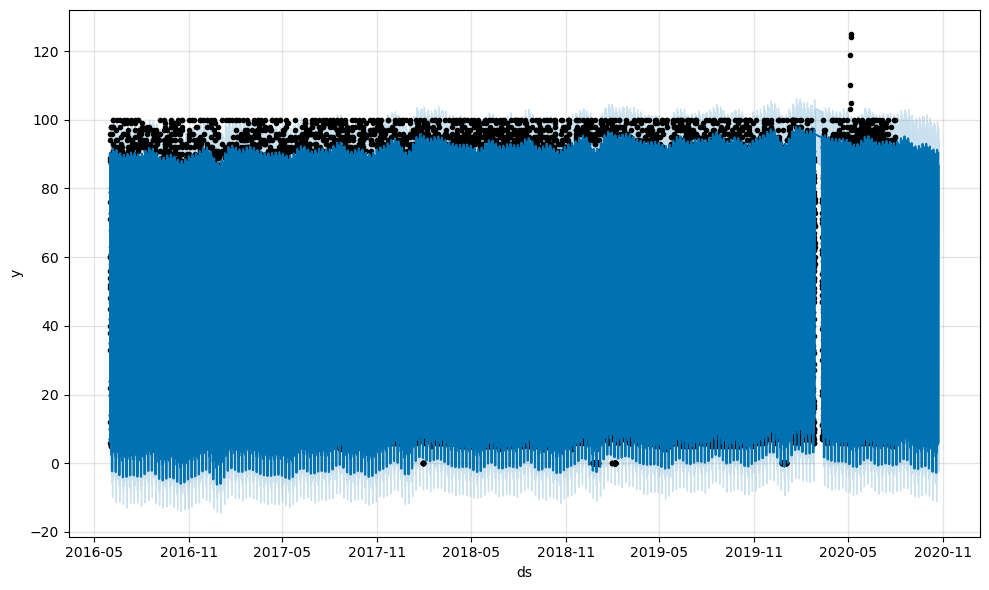

In [89]:
# Plot the Prophet predictions for the Mercado trends data
fig = model.plot(forecast_mercado_trends)
plt.show()



##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** The historical data looks stable with an anomily shown in late 2019. Future forecasting shows that there won't be too much fluctution.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [90]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index('ds', inplace=True)

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame

display(forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].head())

,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 09:00:00,7.669312,-0.333494,15.919826
2016-06-01 10:00:00,14.157949,6.139488,22.402707
2016-06-01 11:00:00,23.277197,16.120092,31.199887
2016-06-01 12:00:00,33.102305,24.621928,41.740989
2016-06-01 13:00:00,41.827790,33.700255,49.545556


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

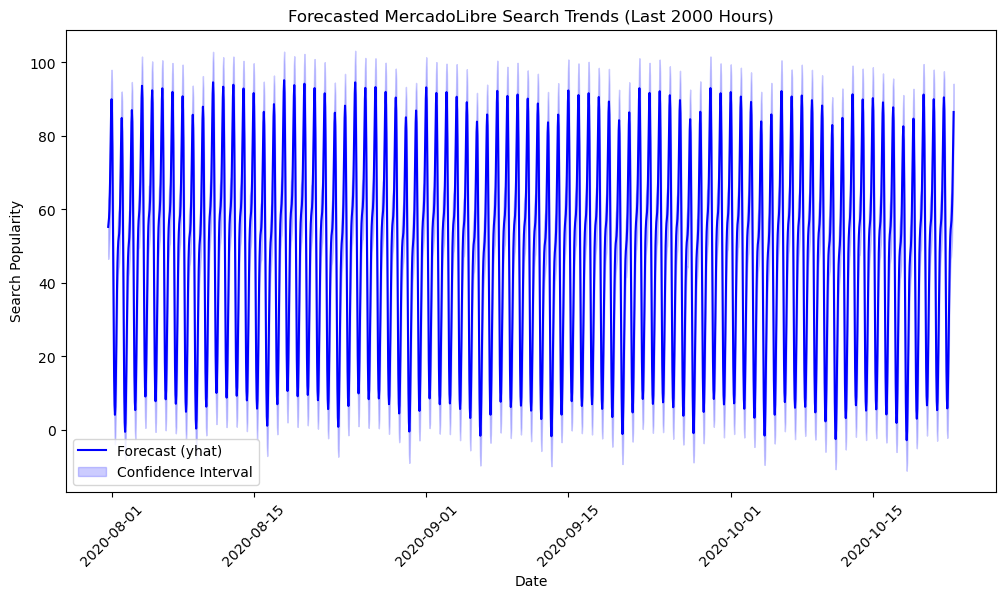

In [91]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours



# Select the last 2000 hours of data
forecast_last_2000 = forecast_mercado_trends.tail(2000)

# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(forecast_last_2000.index, forecast_last_2000['yhat'], label='Forecast (yhat)', color='blue')
plt.fill_between(forecast_last_2000.index, 
                 forecast_last_2000['yhat_lower'], 
                 forecast_last_2000['yhat_upper'], 
                 color='blue', alpha=0.2, label='Confidence Interval')

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Search Popularity")
plt.title("Forecasted MercadoLibre Search Trends (Last 2000 Hours)")
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.show()


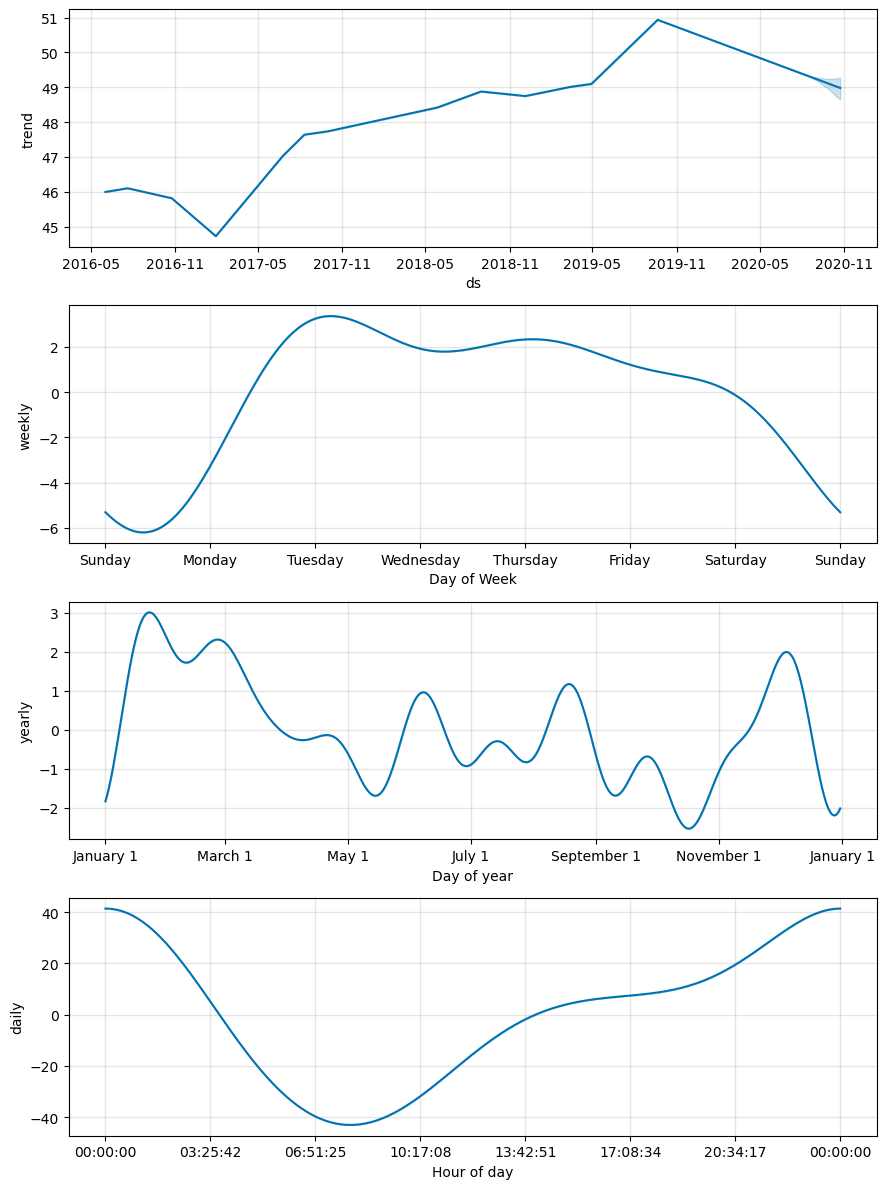

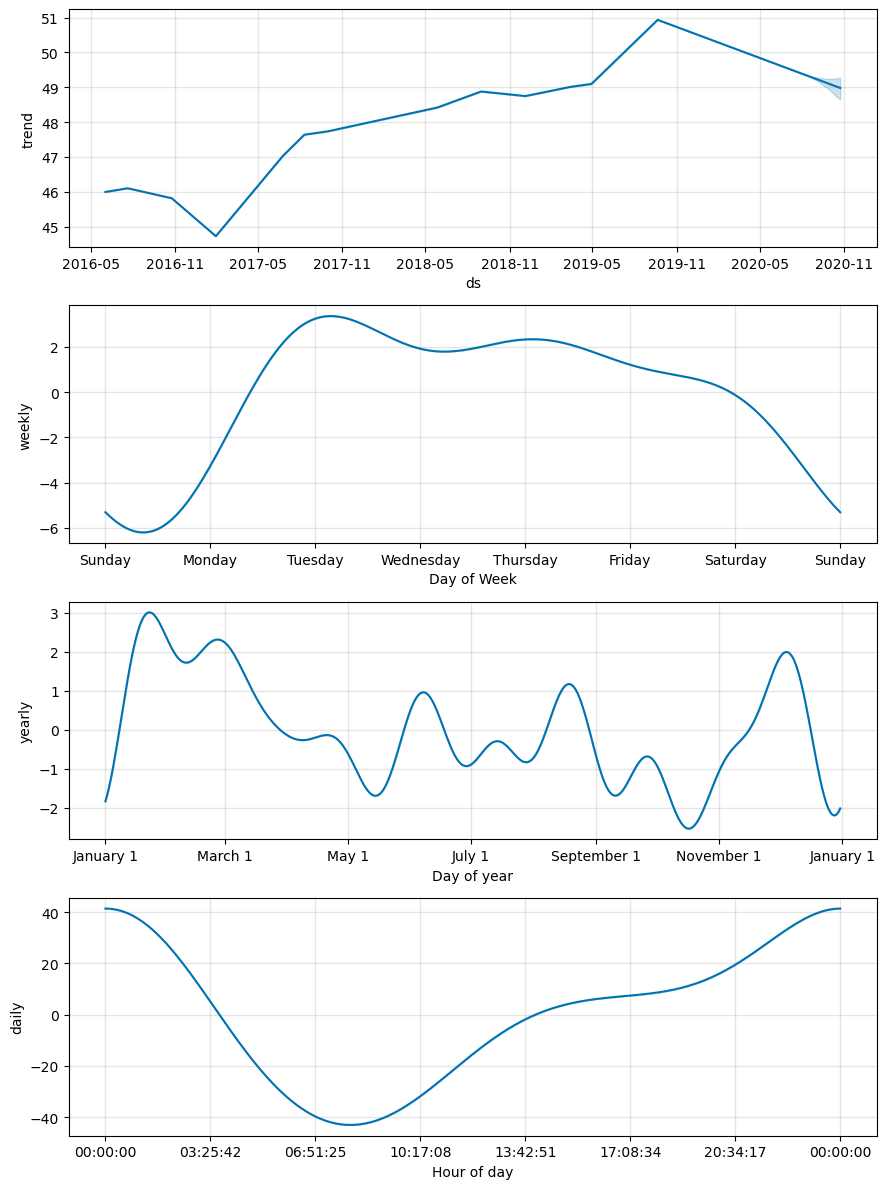

In [93]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends = forecast_mercado_trends.reset_index()

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
fig = model.plot_components(forecast_mercado_trends)

plt.show()

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** From the display, it looks like midnight shows the greatest populatiry.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** The data shows that Tuesday gets the most traffic.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** It looks like October represents the lowest point in search traffic during the calendar year.
